# Load Constrained Wake Steering Optimization

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/wake_steering_and_loads.ipynb) (requires google account)


In this example, we perform an active yaw (wake steering) optimization while considering the fatigue loading as constraint. Here, the design variables are changed to the yaw angles of the turbines, which are dependent on the number of turbines and the wind speed and wind direction cases selected. In addition, we need to specify the wake deflection model to represent the wake behind the turbine as accurate as possible.

Load calculations of the Damage Equivalent Loads (DEL) and Lifetime Damage Equivalent Loads (LDEL) are computed via PyWake for the turbines and flow cases selected. Then, the load constraints can be included either with the `AEPMaxLoadCostModel` or as **post_constraints** in the `TopFarmProblem`. Both types of set ups are included in this example.

**Install TopFarm and PyWake if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

**Note:** The `surrogates_interface` package is required to import `IEA34_130_1WT_Surrogate` from `py_wake`. If you encounter a `ModuleNotFoundError`, install `surrogates_interface` by running:

In [ ]:
from py_wake.examples.data.iea34_130rwt import IEA34_130_1WT_Surrogate 
if not importlib.util.find_spec("surrogates_interface"):
    !pip install surrogates_interface==2.2.1 --index-url https://gitlab.windenergy.dtu.dk/api/v4/projects/2552/packages/pypi/simple --ignore-requires-python

**First we import basic Python elements and some Topfarm classes**

In [1]:
import numpy as np
from numpy import newaxis as na
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from topfarm.cost_models.cost_model_wrappers import AEPMaxLoadCostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot

from py_wake.examples.data.lillgrund import LillgrundSite
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian, NiayifarGaussian
from py_wake.turbulence_models.stf import STF2017TurbulenceModel
from py_wake.examples.data.iea34_130rwt import IEA34_130_1WT_Surrogate 
from py_wake.deflection_models.jimenez import JimenezWakeDeflection
from py_wake.superposition_models import MaxSum
from py_wake.wind_turbines.power_ct_functions import SimpleYawModel

**Next, we select the site and wind turbine to use**.

Usually, adding the loads as constraints into TOPFARM's problem requires an accurate calculation of the fatigue loading, which here is done by a surrogate of the IEA3 3.4MW turbine. In addition, it is necessary to specify a turbulence model (`STF2017TurbulenceModel`) that is adequate enough to represent the turbulence intensity in the site, which the surrogate model for the turbine will need for the load calculation. For the wake deflection, we will use the `JimenezWakeDeflection` model.

For more information about wake models, please see: https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/EngineeringWindFarmModels.html

In [2]:
site = LillgrundSite()
windTurbines = IEA34_130_1WT_Surrogate()
wfm = IEA37SimpleBastankhahGaussian(site, windTurbines,deflectionModel=JimenezWakeDeflection(), turbulenceModel=STF2017TurbulenceModel(addedTurbulenceSuperpositionModel=MaxSum()))

#choosing the flow cases for the optimization - this will determine the speed and accuracy of the simulation
wsp = np.asarray([10, 15])
wdir = np.asarray([90])

1/1 [==============================] - 0s 47ms/step


**Next, we set up the load constraint**

In this example, we will calculate nominal loads and use this as a basis for the load constraint. The loads are represented by the Lifetime Damage Equivalent Loads (LDEL).

In [3]:
%%capture
x, y = site.initial_position.T

#keeping only every second turbine as lillegrund turbines are approx. half the size of the iea 3.4MW
x = x[::2]
y = y[::2]
n_wt = x.size

#setting up the size of the yaw angle to represent the number of turbines, wind speeds and wind directions used
i = n_wt
k = wsp.size
l = wdir.size
yaw_zero = np.zeros((i, l, k))

#choosing a load ratio for the constraint
load_fact = 1.02
simulationResult = wfm(x,y,wd=wdir, ws=wsp, yaw=yaw_zero, tilt=0)
nom_loads = simulationResult.loads('OneWT')['LDEL'].values
max_loads = nom_loads * load_fact

**Setting up optimization problem**

In [4]:
#parameters needed for the optimization
maxiter = 5
driver = EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter)
yaw_min, yaw_max =  - 40, 40
yaw_init = np.zeros((i, l, k))
tol = 1e-8
ec = 1e-4
step = 1e-2

#setting up cost function - aep and nominal loads calculation
def aep_load_func(yaw_ilk):
    simres = wfm(x, y, wd=wdir, ws=wsp, yaw=yaw_ilk, tilt=0)
    aep = simres.aep().sum()
    loads = simres.loads('OneWT')['LDEL'].values
    return [aep, loads]

**Now, we can set up the gradient function used in the optimization**

For some problems it is sufficient to rely on the automatic finite difference calculated by OpenMDAO or you can specify the explicit gradients from your model. In this case we don't have explicit gradients but the automatic finite difference is also inefficient, so we do a manual population of the Jacobian.

In [5]:
s = nom_loads.shape[0]
P_ilk = np.broadcast_to(simulationResult.P.values[na], (i, l, k))
lifetime = float(60 * 60 * 24 * 365 * 20)
f1zh = 10.0 ** 7.0
lifetime_on_f1zh = lifetime / f1zh
indices = np.arange(i * l * k).reshape((i, l, k))

def aep_load_gradient(yaw_ilk):
    simres0 = wfm(x, y, wd=wdir, ws=wsp, yaw=yaw_ilk, tilt=0)
    aep0 = simres0.aep()
    DEL0 = simulationResult.loads('OneWT')['DEL'].values
    LDEL0 = simulationResult.loads('OneWT')['LDEL'].values
    d_aep_d_yaw = np.zeros(i*l*k)
    d_load_d_yaw = np.zeros((s * i, i * l * k))
    for n in range(n_wt):
        yaw_step = yaw_ilk.copy()
        yaw_step = yaw_step.reshape(i, l, k)
        yaw_step[n, :, :] += step
        simres_fd = wfm(x, y, wd=wdir, ws=wsp, yaw=yaw_step, tilt=0)
        aep_fd = simres_fd.aep()
        d_aep_d_yaw[n * l * k : (n + 1) * l * k] = (((aep_fd.values - aep0.values) / step).sum((0))).ravel()
        
        DEL_fd = simres_fd.loads('OneWT')['DEL'].values
        for _ls in range(s):
            m = simulationResult.loads('OneWT').m.values[_ls]
            for _wd in range(l):
                for _ws in range(k):
                    DEL_fd_fc = DEL0.copy()
                    DEL_fd_fc[:, :, _wd, _ws] = DEL_fd[:, :, _wd, _ws]
                    DEL_fd_fc = DEL_fd_fc[_ls, :, :, :]
                    f = DEL_fd_fc.mean()
                    LDEL_fd = (((P_ilk * (DEL_fd_fc/f) ** m).sum((1, 2)) * lifetime_on_f1zh) ** (1/m))*f
                    d_load_d_yaw[n_wt * _ls : n_wt * (_ls + 1), indices[n, _wd, _ws]] = (LDEL_fd - LDEL0[_ls]) / step

    return d_aep_d_yaw, d_load_d_yaw

**Specifying the cost component and topfarm problem**

In [6]:
cost_comp = AEPMaxLoadCostModelComponent(input_keys=[('yaw_ilk', np.zeros((i, l, k)))],
                                          n_wt = n_wt,
                                          aep_load_function = aep_load_func,
                                          aep_load_gradient = aep_load_gradient,
                                          max_loads = max_loads, 
                                          objective=True,
                                          income_model=True,
                                          output_keys=[('AEP', 0), ('loads', np.zeros((s, i)))]
                                          )

problem = TopFarmProblem(design_vars={'yaw_ilk': (yaw_init, yaw_min, yaw_max)},
                          n_wt=n_wt,
                          cost_comp=cost_comp,
                          driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
                          plot_comp=NoPlot(),
                          expected_cost=ec)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


**Now we run the optimization**

In [7]:
%%capture
cost, state, recorder = problem.optimize()

**We can also do some plotting to visualize the final yaw angles found by the optimizer for a given flow case**

In [8]:
%%capture
simulationResult = wfm(x,y,wd=wdir[0], ws=wsp[0], yaw=state['yaw_ilk'][:,0,0], tilt=0)

Text(0, 0.5, 'y [m]')

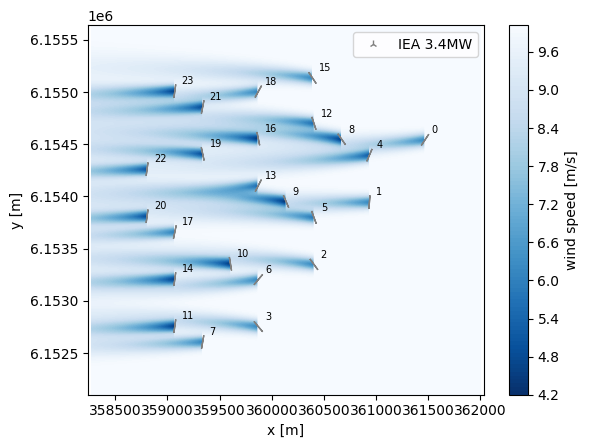

In [10]:
plt.figure()
simulationResult.flow_map().plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')

### Note:

Due to the computational expensive nature of this problem, the maximum number of iterations were restricted to 5, for educational purposes. To see a convergence in loading and AEP, the number of iterations must be increased.

### Setting up the load constraints as post_constraints

Alternatively to using the `AEPMaxLoadCostModelComponent`, the common `CostModelComponent` can also be used any load constrained problem. The main difference lies in the way the load constraints are specified within the `TopFarmProblem`. You should set up the load constraint as a **post_constraints** element. Below is an example on how to set up this type of problem.

In [14]:
from topfarm.cost_models.cost_model_wrappers import CostModelComponent

#setting up the cost model component and topfarm problem

cost_comp = CostModelComponent([('yaw_ilk', np.zeros((i, l, k)))],
                            n_wt=n_wt,
                            cost_function=aep_load_func,
                            cost_gradient_function=aep_load_gradient, 
                            objective=True,
                            output_keys=[('AEP', 0.0), ('loads', np.zeros((s, i)))])

#parameters for optimization
maxiter = 5
tol = 1e-4
ec = 1

problem = TopFarmProblem(design_vars={'yaw_ilk': (yaw_init, yaw_min, yaw_max)},
                          n_wt = n_wt,
                          post_constraints=[('loads', {'upper': max_loads})],
                          cost_comp=cost_comp,
                          driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
                          plot_comp=NoPlot(),
                          expected_cost=ec)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


We can evaluate the topfarm problem to make sure it is set up properly without having to run the optimization again.

In [12]:
%%capture
problem.evaluate()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


Evaluating the topfarm problem yields the initial conditions in terms of AEP and position of the turbines:

    (72.12110945807837,
     {'yaw_ilk': array([[[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]],
  
         [[0., 0.]]])})